In [43]:
import queue
from experiment_information import *
from experiments.sweep_generalization_error import *
from data import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as np
import numpy as np
import logging
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_erm = dbHandler.get_erms()
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()
print("Current code version, ", __version__)

Current code version,  23


In [45]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
# version_choice = "13"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(2)

,experiment_id,experiment_name,duration,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,lambdas,taus,d,erm_methods,completed
36,6378d7b2-34e9-4397-b559-8ce06048405a,Default Experiment,1553.914678,23,2023-04-06 15:37:30,1,10,"[0.1, 0.8666666666666667, 1.6333333333333335, ...","[0.0, 0.1, 0.2, 0.3]",[0],[0],1000,"[""sklearn""]",1
34,9823a8b1-2d44-401b-8e0b-9c696d5fdf5f,Default Experiment,1117.421143,23,2023-04-06 15:05:43,1,10,"[0.1, 0.8666666666666667, 1.6333333333333335, ...","[0.0, 0.1, 0.2, 0.3]",[1],[0],1000,"[""sklearn""]",1


In [46]:
# extract and print the top experiment_id
experiment_id = df_experiments.iloc[0]["experiment_id"]
print(experiment_id)

6378d7b2-34e9-4397-b559-8ce06048405a


In [47]:
import struct
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
# round alphas to 2 decimals
state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: round(x,2))
erm = df_erm[df_erm["experiment_id" ] == experiment_id]
# gd = erm[erm["chosen_minimizer"] == "gd"]
# gd = erm[erm["chosen_minimizer"] == "L-BFGS-B"]
# gd = erm[erm["chosen_minimizer"] == "logistic"]
gd = erm[erm["chosen_minimizer"] == "sklearn"]
# round alphas to 2 decimals
gd["alpha"] = gd["alpha"].apply(lambda x: round(x,2))
# set alpha, epsilon, tau, lam as index in gd and state_evolution
gd = gd.set_index(["alpha","epsilon","tau","lam"])
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam"])
# from state_evolution keep generalization_error, sigma, q, m, cosb
state_evolution = state_evolution[["generalization_error","sigma","q","m","cosb","training_error"]]
# add a suffix _state_evolution to the columns
state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
# from gd keep generalization_error_erm	generalization_error_overlap Q	rho	m	cosb
gd = gd[["generalization_error_erm","generalization_error_overlap","Q","rho","m","cosb", "training_error","d"]]
# add a suffix _erm to the columns
gd.columns = [col+"_erm" for col in gd.columns]
# join the two dataframes
df = state_evolution.join(gd)
# reorder the columns
df = df[['generalization_error_state_evolution', 'generalization_error_erm_erm', 'generalization_error_overlap_erm', 'sigma_state_evolution', 'q_state_evolution','Q_erm','m_state_evolution','m_erm','cosb_state_evolution','cosb_erm', 'rho_erm',"training_error_state_evolution","training_error_erm","d_erm"]]
# average all quantities over the index and obtain also the standard deviation
df = df.groupby(level=[0,1,2,3]).agg([np.mean,np.std])
# display all columns
pd.set_option('display.max_columns', None)
df

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_3068/3975910660.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: round(x,2))


generalization_error_state_evolution       \
                                                      mean  std   
alpha epsilon tau lam                                             
0.10  0.1     0.0 0.0                             0.420279  0.0   
      0.2     0.0 0.0                             0.420272  0.0   
      0.3     0.0 0.0                             0.420268  0.0   
0.87  0.1     0.0 0.0                             0.272920  0.0   
      0.2     0.0 0.0                             0.272361  0.0   
      0.3     0.0 0.0                             0.272071  0.0   
1.63  0.1     0.0 0.0                             0.200182  0.0   
      0.2     0.0 0.0                             0.199390  0.0   
      0.3     0.0 0.0                             0.198953  0.0   
2.40  0.1     0.0 0.0                             0.154567  0.0   
      0.2     0.0 0.0                             0.154059  0.0   
      0.3     0.0 0.0                             0.154301  0.0   
3.17  0.1     0.0 0.0                             0.124518  0.0   
      0.2     0.0 0.0                             0.124901  0.0   
      0.3     0.0 0.0                             0.126614  0.0   
3.93  0.0     0.0 0.0                                  NaN  NaN   
      0.1     0.0 0.0                             0.103985  0.0   
      0.2     0.0 0.0                             0.105577  0.0   
      0.3     0.0 0.0                             0.108617  0.0   
4.70  0.0     0.0 0.0                                  NaN  NaN   
      0.1     0.0 0.0                             0.089478  0.0   
      0.2     0.0 0.0                             0.092190  0.0   
      0.3     0.0 0.0                             0.096133  0.0   
5.47  0.0     0.0 0.0                                  NaN  NaN   
      0.1     0.0 0.0                             0.078881  0.0   
      0.2     0.0 0.0                             0.082458  0.0   
      0.3     0.0 0.0                             0.086963  0.0   
6.23  0.0     0.0 0.0                                  NaN  NaN   
      0.1     0.0 0.0                             0.070883  0.0   
      0.2     0.0 0.0                             0.075075  0.0   
      0.3     0.0 0.0                             0.079916  0.0   
7.00  0.0     0.0 0.0                                  NaN  NaN   
      0.1     0.0 0.0                             0.064660  0.0   
      0.2     0.0 0.0                             0.069272  0.0   
      0.3     0.0 0.0                             0.074306  0.0   

                      generalization_error_erm_erm            \
                                              mean       std   
alpha epsilon tau lam                                          
0.10  0.1     0.0 0.0                     0.417927  0.008083   
      0.2     0.0 0.0                     0.453176  0.014362   
      0.3     0.0 0.0                     0.456650  0.008502   
0.87  0.1     0.0 0.0                     0.400946  0.013167   
      0.2     0.0 0.0                     0.431536  0.008637   
      0.3     0.0 0.0                     0.449491  0.012238   
1.63  0.1     0.0 0.0                     0.365979  0.048177   
      0.2     0.0 0.0                     0.425102  0.027819   
      0.3     0.0 0.0                     0.456857  0.009447   
2.40  0.1     0.0 0.0                     0.280423  0.053519   
      0.2     0.0 0.0                     0.404348  0.044098   
      0.3     0.0 0.0                     0.457747  0.007292   
3.17  0.1     0.0 0.0                     0.258640  0.051456   
      0.2     0.0 0.0                     0.354363  0.063055   
      0.3     0.0 0.0                     0.455744  0.008990   
3.93  0.0     0.0 0.0                     0.109269  0.003291   
      0.1     0.0 0.0                     0.268204  0.058898   
      0.2     0.0 0.0                     0.347340  0.060364   
      0.3     0.0 0.0                     0.463400  0.010276   
4.70  0.0     0.0 0.0                     0.093679  0.002609   
   

In [48]:
def create_plot(df, error_name, state_evolution_name, gd_name):
    df2 = df.reset_index()
    # Define a color palette to use for the different epsilon values
    palette = sns.color_palette(n_colors=len(df2['epsilon'].unique()))

    d = df2['d_erm']["mean"][0]

    for tau in df2['tau'].unique():
        for lam in df2['lam'].unique():
            # Filter the dataframe for the current values of tau and lam
            data = df2[(df2['tau'] == tau) & (df2['lam'] == lam)]
            
            for i, epsilon in enumerate(data['epsilon'].unique()):
                # Filter the dataframe for the current value of epsilon
                epsilon_subset = data[data['epsilon'] == epsilon]

                # Plot the state_evolution results as a line
                plt.plot(epsilon_subset['alpha'], epsilon_subset[(state_evolution_name, 'mean')], label=f'Epsilon: {epsilon}', color=palette[i])
                
                # Plot the gradient_descent results as points with error bars
                plt.errorbar(epsilon_subset['alpha'], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[i], capsize=5)
            
            # Add labels and title
            plt.xlabel('Alpha')
            plt.ylabel(error_name)
            plt.title(f'{error_name} - Tau: {tau}, Lambda: {lam}, d: {d}')
            # Add a legend
            plt.legend()

            name = f"{error_name}_tau_{tau}_lam_{lam}"
            # Save the plot as svg
            plt.savefig(f"Assets/{name}.svg")

            # Show the plot
            plt.show()

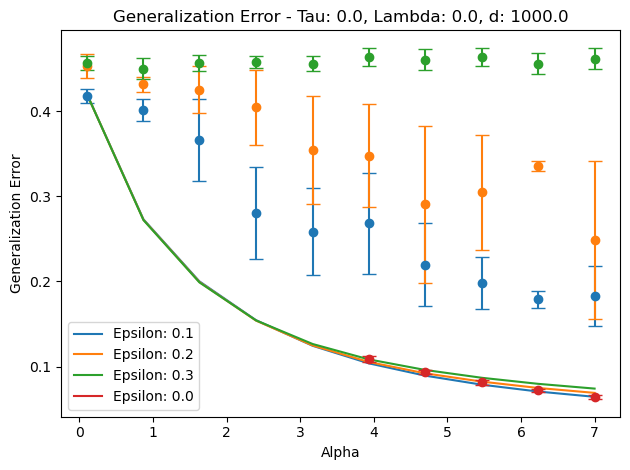

In [49]:
create_plot(df, "Generalization Error", "generalization_error_state_evolution", "generalization_error_erm_erm")

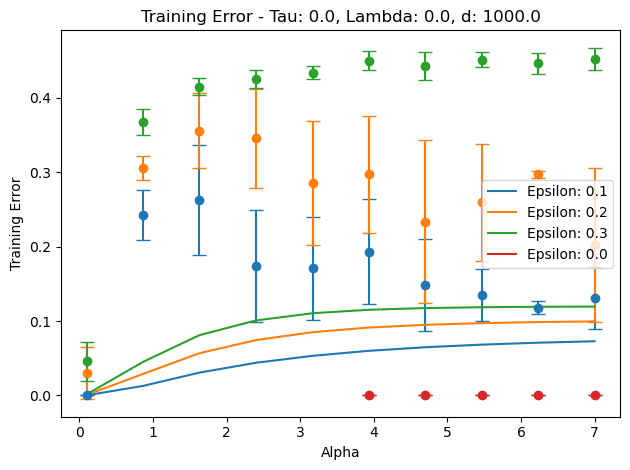

In [50]:
create_plot(df, "Training Error", "training_error_state_evolution", "training_error_erm")

In [51]:
# # Create a SweepExperiment
# experiment = get_default_experiment()
# # use json dump to save the experiment parameters
# with open("sweep_experiment.json","w") as f:
#     # use the NumpyEncoder to encode numpy arrays
#     json.dump(experiment.__dict__,f,cls=NumpyEncoder)